In [82]:
file_path = 'hardest.mp3'
downsampling_rate = 32
show_chroma = 0
show_downsample = 0
show_raw_ssm = 0

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import librosa

def convolve(image, kernel):
    image, kernel = np.asarray(image), np.asarray(kernel, float)
    if len(image.shape) == 1: image = image[np.newaxis,:]
    if len(image.shape) == 1: kernel = kernel[np.newaxis,:]

    if image.size < kernel.size:
        image, kernel = kernel, image

    g = np.zeros(np.array(image.shape) + np.array(kernel.shape) - 1)
    if kernel.ndim == 2:
        H, W = image.shape
        for (r, c) in np.transpose(np.nonzero(kernel)):
            g[r:r+H, c:c+W] += image * kernel[r,c]

    if kernel.ndim == 3:
        D, H, W = image.shape
        for (D, H, W) in np.transpose(np.nonzero(kernel)):
            g[d:d+D, r:r+H, c:c+W] += image * kernel[d,r,c]

    additional_size = kernel.shape[0]//2, kernel.shape[1]//2
    image_size = g.shape
    return g[additional_size[0]:image_size[0]-additional_size[0],
             additional_size[1]:image_size[1]-additional_size[1]]
        

y, sr = librosa.load(file_path)

# Here feature vector is created
# Uncomment for Chromagram
feature = librosa.feature.chroma_cens(y=y, sr=sr)

# Uncomment for MFCC
#feature = librosa.feature.mfcc(y=y, sr=sr)

# Uncomment for Tempogram
#oenv = librosa.onset.onset_strength(y=y, sr=sr)
#feature = librosa.feature.tempogram(onset_envelope=oenv, sr=sr)

if show_chroma:
    librosa.display.specshow(feature, sr=sr, x_axis='time')
    plt.title('Feature sequence')
    plt.colorbar()
    plt.show()

# Here chromagram is downsampled
N = feature.shape[1]/downsampling_rate
F = feature.shape[0]
ds = np.ndarray((F,N))
for i in np.arange(N):
    ds[:,i] = np.mean(feature[:,downsampling_rate*i:downsampling_rate*(i+1)],axis=1)

if show_downsample:
    librosa.display.specshow(ds, sr=sr, x_axis='time')
    plt.title('Feature sequence')
    plt.colorbar()
    plt.show()
    
# Here raw ssm is created
out = np.ndarray((N,N))
for i in np.arange(N):
    a = ds[:,i]
    for j in np.arange(N):
        b = ds[:,j]
        out[i,j] = np.dot(a,b)#/(np.linalg.norm(a)*np.linalg.norm(b))

if show_raw_ssm:
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(out, x_axis='time', y_axis='time', sr=sr/downsampling_rate, n_xticks=12)
    plt.title('ssm')
    plt.colorbar()
    plt.show()

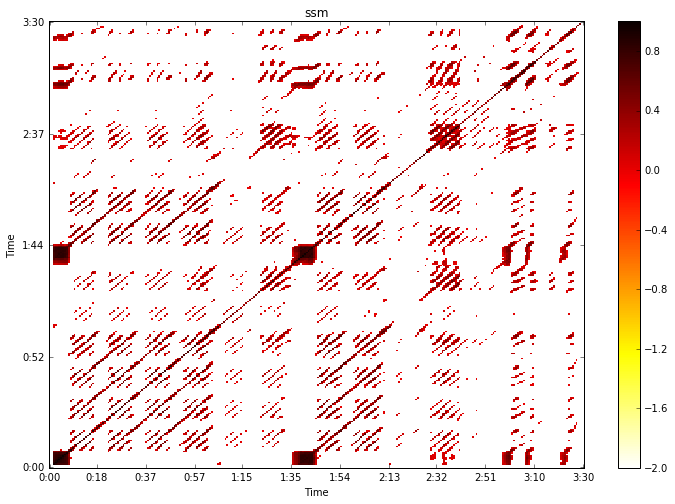

In [83]:
# Convolution raw ssm enhancing diagonal path
kernel_size = 8
kernel = np.identity(6)
blur_out = convolve(out, kernel/kernel_size)

# Normalizing value between 0 and 1 and applying threshold so some values get penalties
negative = (blur_out<0.69)*2
positive = blur_out*(blur_out>0.69)-(blur_out>0.69)*0.69
positive = positive/positive.max()
blur_out = positive-negative

plt.figure(figsize=(12, 8))
librosa.display.specshow(blur_out, x_axis='time', y_axis='time', sr=sr/downsampling_rate, n_xticks=12)
plt.title('ssm')
plt.colorbar()
plt.set_cmap('hot_r')
plt.show()